In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from joblib import dump
from xgboost import XGBClassifier
plt.rcParams['figure.figsize'] = [20,10]

In [2]:
data = pd.read_csv('transactions_train.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [3]:
responseVar = data.isFraud.to_numpy()
responseVar
data['deltaBalanceOrig'] = data.newbalanceOrig - data.oldbalanceOrig
data['deltaBalanceDest'] = -data.newbalanceDest + data.oldbalanceDest
data['prevStep'] = data['step'].shift(1)
data['diffTime'] = data['step'] - data['prevStep']
data['prevAmt'] = data['amount'].shift(1)
data['aggAmt'] = data['amount'] + data['prevAmt']
data['prevNameOrig'] = data['nameOrig'].shift(1)
data['prevNameDest'] = data['nameDest'].shift(1)
data['nameOrigBool'] = data['nameOrig'] == data['prevNameOrig']
data['nameDestBool'] = data['nameDest'] == data['prevNameDest']
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,deltaBalanceOrig,deltaBalanceDest,prevStep,diffTime,prevAmt,aggAmt,prevNameOrig,prevNameDest,nameOrigBool,nameDestBool
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,-9839.64,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,-1864.28,0.0,1.0,0.0,9839.64,11703.92,C1231006815,M1979787155,False,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,-181.00,0.0,1.0,0.0,1864.28,2045.28,C1666544295,M2044282225,False,False
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,-181.00,21182.0,1.0,0.0,181.00,362.00,C1305486145,C553264065,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,-11668.14,0.0,1.0,0.0,181.00,11849.14,C840083671,C38997010,False,False


In [4]:
features = data.loc[:,['amount','deltaBalanceDest','step','prevStep','type',
                       'oldbalanceOrig','newbalanceOrig','newbalanceDest','oldbalanceDest',
                       'deltaBalanceOrig','prevAmt','diffTime','aggAmt','nameOrigBool','nameDestBool']]
features

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,diffTime,aggAmt,nameOrigBool,nameDestBool
0,9839.64,0.00,1,NaN,PAYMENT,170136.00,160296.36,0.00,0.00,-9839.64,NaN,NaN,NaN,False,False
1,1864.28,0.00,1,1.0,PAYMENT,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,0.0,11703.92,False,False
2,181.00,0.00,1,1.0,TRANSFER,181.00,0.00,0.00,0.00,-181.00,1864.28,0.0,2045.28,False,False
3,181.00,21182.00,1,1.0,CASH_OUT,181.00,0.00,0.00,21182.00,-181.00,181.00,0.0,362.00,False,False
4,11668.14,0.00,1,1.0,PAYMENT,41554.00,29885.86,0.00,0.00,-11668.14,181.00,0.0,11849.14,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,699.0,TRANSFER,162326.52,0.00,0.00,0.00,-162326.52,573.88,0.0,162900.40,False,False
6351189,162326.52,-162326.52,699,699.0,CASH_OUT,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,0.0,324653.04,False,False
6351190,2763398.31,0.00,699,699.0,TRANSFER,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,0.0,2925724.83,False,False
6351191,2763398.31,-2763398.31,699,699.0,CASH_OUT,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,0.0,5526796.62,False,False


In [5]:
cat_scaler = OrdinalEncoder(handle_unknown='use_encoded_value',
                            unknown_value=np.nan).fit(features.loc[:,'type'].values.reshape(-1,1))
features.loc[:,'type'] = cat_scaler.transform(features.loc[:,'type'].values.reshape(-1,1))
features['prevType'] = features['type'].shift(1)
features['diffType'] = features['type'] - features['prevType']
features

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,diffTime,aggAmt,nameOrigBool,nameDestBool,prevType,diffType
0,9839.64,0.00,1,NaN,3.0,170136.00,160296.36,0.00,0.00,-9839.64,NaN,NaN,NaN,False,False,NaN,NaN
1,1864.28,0.00,1,1.0,3.0,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,0.0,11703.92,False,False,3.0,0.0
2,181.00,0.00,1,1.0,4.0,181.00,0.00,0.00,0.00,-181.00,1864.28,0.0,2045.28,False,False,3.0,1.0
3,181.00,21182.00,1,1.0,1.0,181.00,0.00,0.00,21182.00,-181.00,181.00,0.0,362.00,False,False,4.0,-3.0
4,11668.14,0.00,1,1.0,3.0,41554.00,29885.86,0.00,0.00,-11668.14,181.00,0.0,11849.14,False,False,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,699.0,4.0,162326.52,0.00,0.00,0.00,-162326.52,573.88,0.0,162900.40,False,False,3.0,1.0
6351189,162326.52,-162326.52,699,699.0,1.0,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,0.0,324653.04,False,False,4.0,-3.0
6351190,2763398.31,0.00,699,699.0,4.0,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,0.0,2925724.83,False,False,1.0,3.0
6351191,2763398.31,-2763398.31,699,699.0,1.0,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,0.0,5526796.62,False,False,4.0,-3.0


In [12]:
#seed = 42
#Xtrain,Xtest,ytrain,ytest = train_test_split(features,responseVar,test_size=0.2,stratify=responseVar, random_state=seed)
trainLen = round(len(features)*0.8)
Xtrain = features.loc[0:trainLen-1,:]
ytrain = responseVar[:trainLen]
Xtest = features.loc[trainLen:,:]
ytest = responseVar[trainLen:]

In [20]:
mdl = XGBClassifier(use_label_encoder=False,verbosity=2)
mdl.fit(Xtrain,ytrain)

[23:11:36] INFO: ../src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:11:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:11:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:11:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[23:11:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[23:11:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pru

[23:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:16:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[23:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[23:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:16:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[23:16:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[23:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:16:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=2)

In [21]:
mdl.score(Xtrain,ytrain)

0.9999952764776063

In [22]:
preds = mdl.predict(Xtest)
acc = accuracy_score(ytest,preds)
f1 = f1_score(ytest,preds)
prec = precision_score(ytest,preds)
recall = recall_score(ytest,preds)
AUC = roc_auc_score(ytest,preds)
print(acc, f1, prec, recall, AUC)

0.9999787441575956 0.9964110062475077 0.9954847277556441 0.9973390101117616 0.998662793545799


In [27]:
dump(mdl,'XGBoostModelFinalSequential.joblib')
dump(cat_scaler,'TypeScalerFinalSequential.joblib')

['TypeScalerFinalSequential.joblib']

In [23]:
print(np.c_[features.columns,mdl.feature_importances_])

[['amount' 0.048474572598934174]
 ['deltaBalanceDest' 0.06488865613937378]
 ['step' 0.007572797127068043]
 ['prevStep' 0.004242907743901014]
 ['type' 0.12388365715742111]
 ['oldbalanceOrig' 0.028789617121219635]
 ['newbalanceOrig' 0.10410507023334503]
 ['newbalanceDest' 0.20021741092205048]
 ['oldbalanceDest' 0.01455653179436922]
 ['deltaBalanceOrig' 0.05319463089108467]
 ['prevAmt' 0.03927704319357872]
 ['diffTime' 0.026212656870484352]
 ['aggAmt' 0.04394492879509926]
 ['nameOrigBool' 0.0]
 ['nameDestBool' 0.0]
 ['prevType' 0.003310828236863017]
 ['diffType' 0.2373286932706833]]


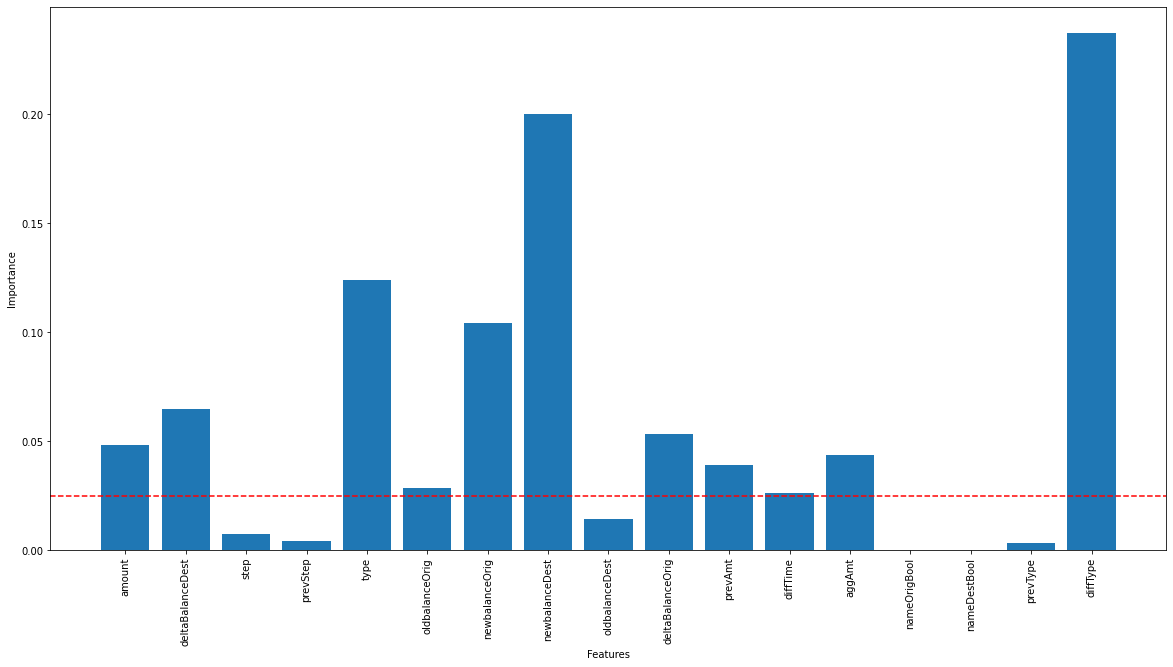

In [24]:
plt.bar(features.columns,mdl.feature_importances_)
plt.axhline(y=0.025,color='r',linestyle='--')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

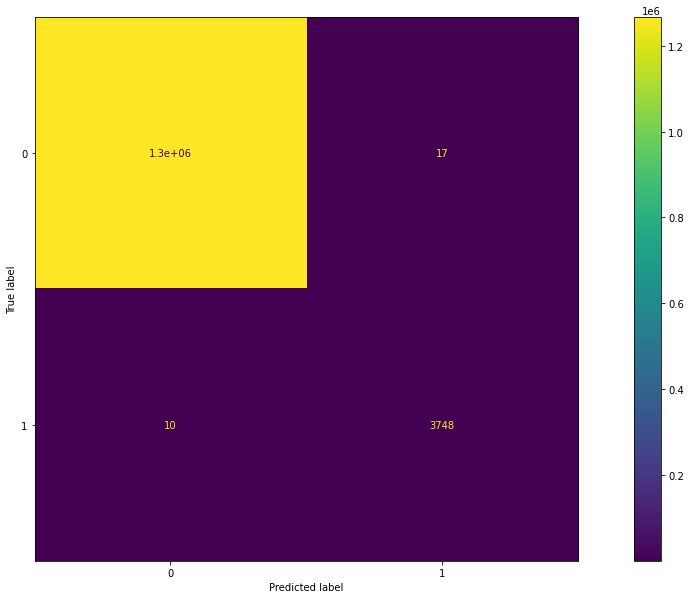

In [25]:
cm = confusion_matrix(ytest, preds, labels=mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl.classes_)
disp.plot()
plt.show()

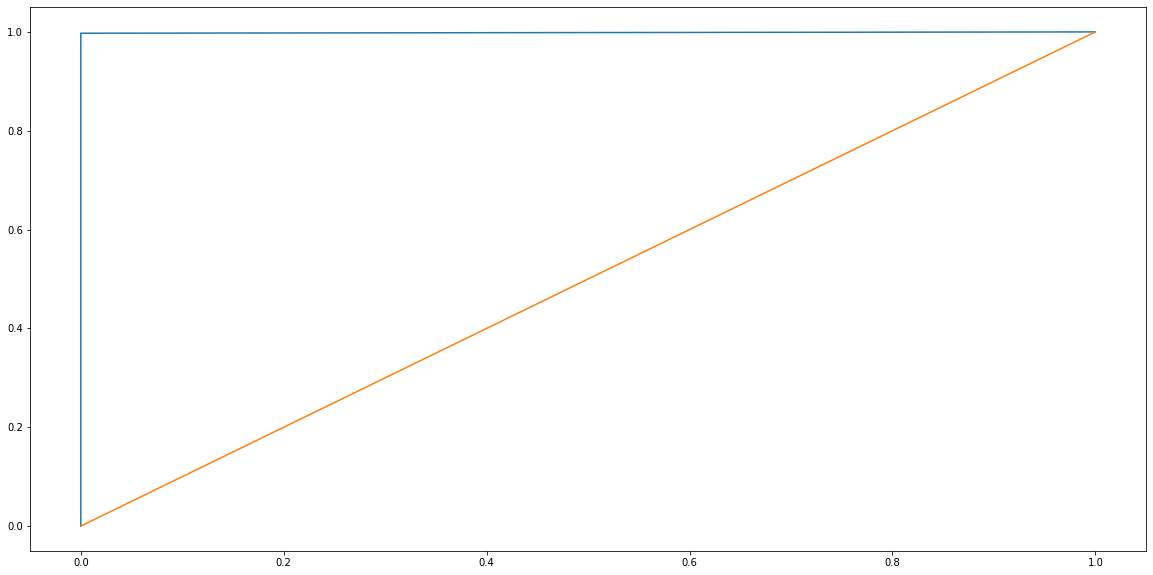

In [26]:
fpr, tpr, thresh = roc_curve(ytest,preds)
f, ax = plt.subplots(1)
ax.plot(fpr,tpr)
ax.plot([0,1])
plt.show()

In [28]:
Xtrain

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,diffTime,aggAmt,nameOrigBool,nameDestBool,prevType,diffType
0,9839.64,0.00,1,NaN,3.0,170136.0,160296.36,0.00,0.00,-9839.64,NaN,NaN,NaN,False,False,NaN,NaN
1,1864.28,0.00,1,1.0,3.0,21249.0,19384.72,0.00,0.00,-1864.28,9839.64,0.0,11703.92,False,False,3.0,0.0
2,181.00,0.00,1,1.0,4.0,181.0,0.00,0.00,0.00,-181.00,1864.28,0.0,2045.28,False,False,3.0,1.0
3,181.00,21182.00,1,1.0,1.0,181.0,0.00,0.00,21182.00,-181.00,181.00,0.0,362.00,False,False,4.0,-3.0
4,11668.14,0.00,1,1.0,3.0,41554.0,29885.86,0.00,0.00,-11668.14,181.00,0.0,11849.14,False,False,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080949,1795.71,0.00,355,355.0,3.0,0.0,0.00,0.00,0.00,0.00,276849.88,0.0,278645.59,False,False,1.0,2.0
5080950,178977.40,198727.11,355,355.0,0.0,10640.0,189617.40,98639.89,297367.00,178977.40,1795.71,0.0,180773.11,False,False,3.0,-3.0
5080951,83818.79,-157249.47,355,355.0,1.0,7702.0,0.00,1273674.60,1116425.13,-7702.00,178977.40,0.0,262796.19,False,False,0.0,1.0
5080952,214698.14,-214698.14,355,355.0,1.0,20040.0,0.00,392806.78,178108.64,-20040.00,83818.79,0.0,298516.93,False,False,1.0,0.0


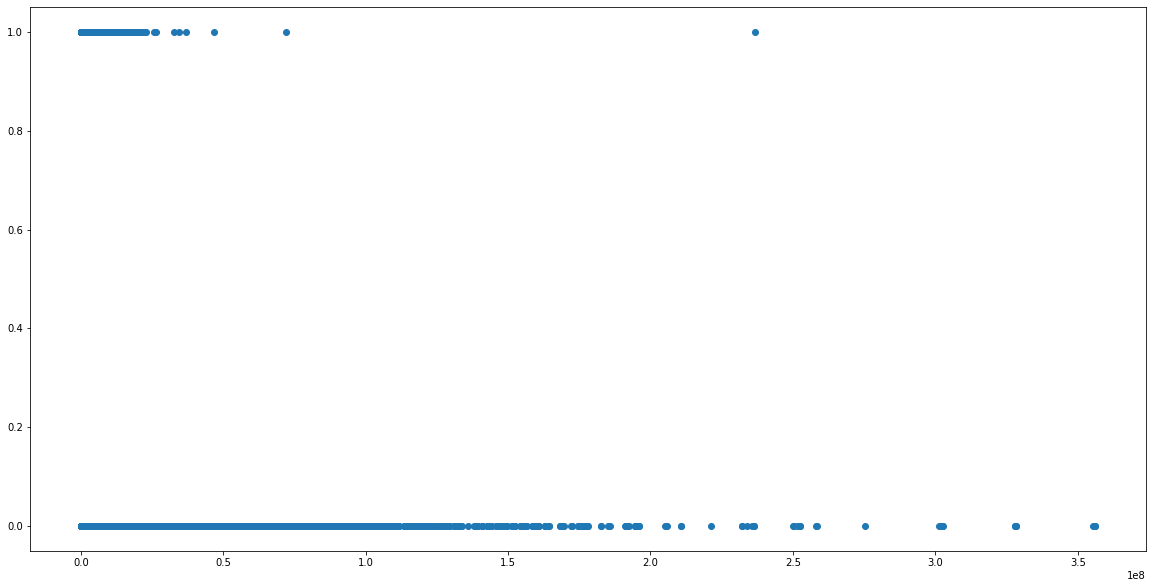

In [29]:
plt.scatter(Xtest.newbalanceDest,ytest)
plt.show()